In [17]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

In [18]:
from config import Config

cfg = Config().replace(
    EPOCHS=200,
    BATCH_SIZE=16,
    multiples_to_log_train_map=10,
    DATASET_PATH='../downloads/sampah_uas/train',
    anns_file_path='../downloads/sampah_uas/train/_annotations.coco.json',
    VAL_DATASET_PATH='../downloads/sampah_uas/valid',
    val_anns_file_path='../downloads/sampah_uas/valid/_annotations.coco.json',
    TEST_DATASET_PATH='../downloads/sampah_uas/test',
    test_anns_file_path='../downloads/sampah_uas/test/_annotations.coco.json',
)

In [19]:
from models.resnet34_yolo import resnet34_yolo as used_model
import config
import torch

folder = "../runs/ResNet/dropout-0.1/2023-19-12_19-19-01"
path_to_model = folder + "/model.pt"
dropout = 0.1

model = used_model(split_size=cfg.SPLIT_SIZE, num_boxes=cfg.NUM_BOXES, num_classes=cfg.NUM_CLASSES, dropout_percentage=cfg.DROPOUT).to(cfg.DEVICE)
model.load_state_dict(torch.load(path_to_model, map_location=torch.device(cfg.DEVICE)))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
from utils import numel

print('Number of parameters: %d' % numel(model))

Number of parameters: 25594203


In [21]:
IMAGE_SIZE = 448

data_preprocess = A.Compose(
    [
        A.LongestMaxSize(max_size=IMAGE_SIZE),
        A.PadIfNeeded(
            min_height=IMAGE_SIZE, min_width=IMAGE_SIZE, border_mode=cv2.BORDER_CONSTANT
        ),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1], max_pixel_value=255,),
        ToTensorV2(),
    ],
    bbox_params=A.BboxParams(format="yolo", min_visibility=0.4, label_fields=[]),
)

In [22]:
from utils import (
    plot_image_on_ax,
    cellboxes_to_boxes,
    non_max_suppression,
)
from taco_dataset import CoCoDatasetForYOLO
import pandas as pd

test_dataset = CoCoDatasetForYOLO(
    root=cfg.TEST_DATASET_PATH,
    annFile=cfg.test_anns_file_path,
    transform=data_preprocess,
    S=cfg.SPLIT_SIZE, B=cfg.NUM_BOXES, C=cfg.NUM_CLASSES
)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


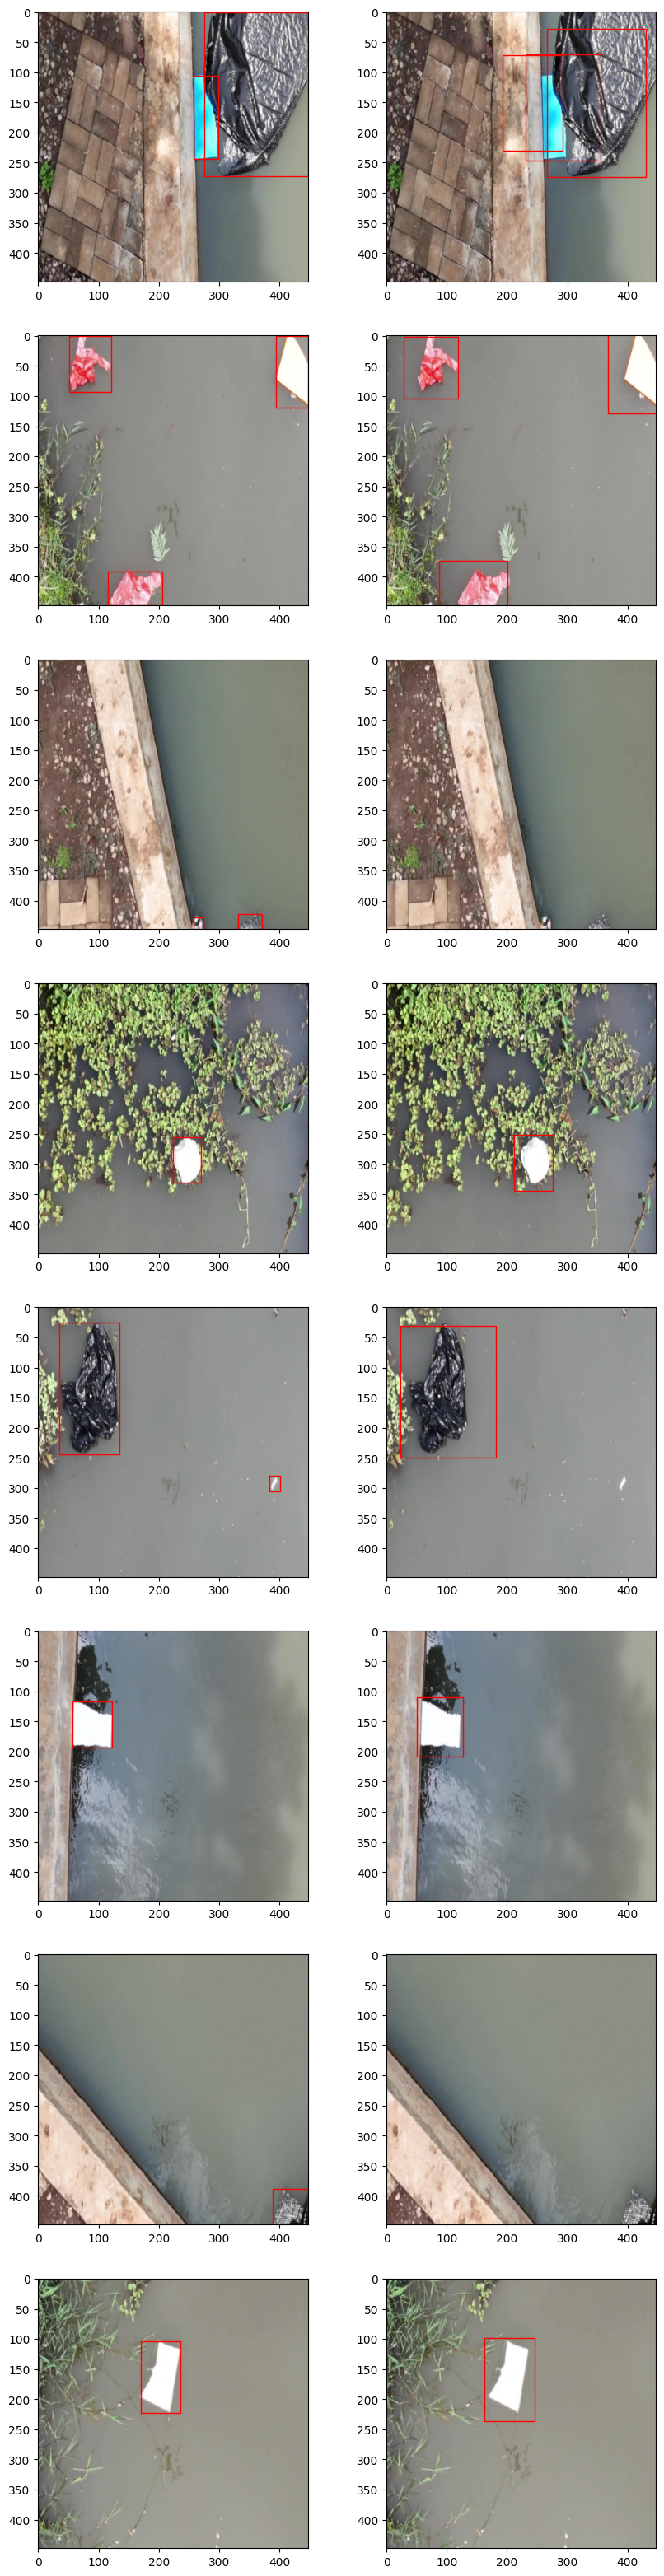

In [41]:
import torchvision.transforms as transforms
import random
import matplotlib.pyplot as plt


fig, axs = plt.subplots(8, 2)

for i in range(8):
    idx = random.randint(0, len(test_dataset))
    data = test_dataset[idx]

    pred = model(data[0].unsqueeze(0))
    pred = cellboxes_to_boxes(pred, S=7, B=2, C=1)
    pred = non_max_suppression(pred[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

    transform = transforms.ToPILImage()
    plot_image_on_ax(transform(data[0]), pred, axs[i][1])

    bboxes = cellboxes_to_boxes(torch.tensor([data[1].tolist()]), S=7, B=2, C=1)
    bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

    transform = transforms.ToPILImage()
    plot_image_on_ax(transform(data[0]), bboxes, axs[i][0])

fig.set_size_inches(w=10, h=40)

plt.show()